# H20 AutoML Kilocalorie Regression
AutoML | H2O | Regression | GBM | GLM | Python | Jupyter Notebook

## Abstract
In this notebook we utilize H20 to generate GBM and GLM models to predict the kilocalories of common foods based on nutritional composition. 

The two models are trained using H20 AutoML, tuned and regularized with key hyperparameters, and then evaluated based on their root mean squared error (RMSE) on the test set. 

Despite an effective implementation of Lasso Regularization that contributed to a 28% reduction in RMSE for our GLM model, the best model was the untuned, GBM model with insignificant features removed (threshold of 0.0004) with a RMSE of ~10.03 on the test dataset. By removing insignificant features we were able to reduce RMSE in the base GBM model by 10% (which had a RMSE of ~11.1 on the test dataset). 

This Model even narrowly outperformed the best model generated by H20 AutoML (RMSE of ~10.3 on the test dataset).

## Modeling with AutoML 
H2O will speed up some of the basic data processing steps, feature engineering, and model testing so I can focus on determining the best model for this dataset.

In [764]:
# Importing necessary libraries
!pip install --upgrade pip
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

In [765]:
!pip3 install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [766]:
# Importing necessary libraries
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
import psutil
import random
import logging
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm

## Virtual Machine Configuration

In [767]:
min_mem_size=6 
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

1


In [768]:
port_no=random.randint(5555,55555)
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)    
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:33384..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4" 2022-07-19; OpenJDK Runtime Environment Temurin-17.0.4+8 (build 17.0.4+8); OpenJDK 64-Bit Server VM Temurin-17.0.4+8 (build 17.0.4+8, mixed mode)
  Starting server from /Users/vraosharma/Desktop/Python/DSEMT/exploratory-data-analysis/venv/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/tmp_glbnpc2
  JVM stdout: /var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/tmp_glbnpc2/h2o_vraosharma_started_from_python.out
  JVM stderr: /var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/tmp_glbnpc2/h2o_vraosharma_started_from_python.err
  Server is running at http://127.0.0.1:33384
Connecting to H2O server at http://127.0.0.1:33384 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_vraosharma_vozf4a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


## Re-acquainting Ourselves with the Data
This project is a continuation of , so I'll be using the [Food Nutrition Dataset](https://www.kaggle.com/datasets/shrutisaxena/food-nutrition-dataset?resource=download&select=food.csv) (which is based on the USDA's [FoodData Central database](https://fdc.nal.usda.gov/fdc-app.html#/)) used in my Predicting Kilocalories with Linear Regression notebook (check that out first to see the profile of the data). Special thanks to SHRUTI SAXENA for compiling this dataset.

In [769]:
# Addding the dataset from github https://github.com/vraosharma-northeastern/exploratory-data-analysis/blob/main/Nutrition%20/food.csv
!wget https://raw.githubusercontent.com/vishnuraosharma/exploratory-data-analysis/main/Kcal%20Predictions/food.csv

zsh:1: command not found: wget


In [770]:
# Reading the file into a dataframe and viewing the first few rows
dff = pd.read_csv('food.csv')

In [771]:
dff.head()

,Category,Description,Nutrient Data Bank Number,Data.Alpha Carotene,Data.Ash,Data.Beta Carotene,Data.Beta Cryptoxanthin,Data.Carbohydrate,Data.Cholesterol,Data.Choline,...,Data.Major Minerals.Potassium,Data.Major Minerals.Sodium,Data.Major Minerals.Zinc,Data.Vitamins.Vitamin A - IU,Data.Vitamins.Vitamin A - RAE,Data.Vitamins.Vitamin B12,Data.Vitamins.Vitamin B6,Data.Vitamins.Vitamin C,Data.Vitamins.Vitamin E,Data.Vitamins.Vitamin K
0,BUTTER,"BUTTER,WITH SALT",1001,0,2.11,158,0,0.06,215,19,...,24,576,0.09,2499,684,0.17,0.003,0.0,2.32,7.0
1,BUTTER,"BUTTER,WHIPPED,WITH SALT",1002,0,2.11,158,0,0.06,219,19,...,26,827,0.05,2499,684,0.13,0.003,0.0,2.32,7.0
2,BUTTER OIL,"BUTTER OIL,ANHYDROUS",1003,0,0.00,193,0,0.00,256,22,...,5,2,0.01,3069,840,0.01,0.001,0.0,2.80,8.6
3,CHEESE,"CHEESE,BLUE",1004,0,5.11,74,0,2.34,75,15,...,256,1395,2.66,763,198,1.22,0.166,0.0,0.25,2.4
4,CHEESE,"CHEESE,BRICK",1005,0,3.18,76,0,2.79,94,15,...,136,560,2.60,1080,292,1.26,0.065,0.0,0.26,2.5


As we can see above, each row represents a food type; the *Description* column contains a breakdown of the few ingredients that comprise the dish or food as well as details of how it was prepared. Some foods have multiple entries in the dataset because they were prepared in different ways, e.g. raw, cooked, fried, etc. Additionally, some foods have multiple entries because they were prepared with different ingredients, e.g. with or without salt, with or without sugar, etc.

As we did in the last notebook, we will do some preprocessing to make this dataset make more sense. We will start by removing the redundant 'Data.' tag from the column names.

In [772]:
#Reading the file into a dataframe and viewing the first few rows
dff = pd.read_csv('food.csv')

# Loop through columns and remove redundant 'Data.' tag from column names
for col in dff.columns:
    new_col = col.replace('Data.', '')  # Remove 'Data.' from the column name
    dff.rename(columns={col: new_col}, inplace=True)  # Rename the column name in dataframe

# Show the first few rows of the dataset
dff.describe()

,Nutrient Data Bank Number,Alpha Carotene,Ash,Beta Carotene,Beta Cryptoxanthin,Carbohydrate,Cholesterol,Choline,Fiber,Kilocalories,...,Major Minerals.Potassium,Major Minerals.Sodium,Major Minerals.Zinc,Vitamins.Vitamin A - IU,Vitamins.Vitamin A - RAE,Vitamins.Vitamin B12,Vitamins.Vitamin B6,Vitamins.Vitamin C,Vitamins.Vitamin E,Vitamins.Vitamin K
count,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,...,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000
mean,14116.443680,21.210711,1.852459,159.043437,8.776744,21.785381,37.162822,20.673546,1.993147,219.655875,...,268.348172,331.590719,1.875125,767.568191,99.437070,1.172903,0.269547,9.075651,0.842837,9.448604
std,8767.416214,269.714183,2.993228,1126.285026,154.184860,27.123491,119.738438,45.481990,4.292873,171.668713,...,404.916220,977.046544,4.193682,3871.307652,761.653061,4.512816,0.565116,63.443284,4.169756,66.067619
min,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8121.000000,0.000000,0.830000,0.000000,0.000000,0.490000,0.000000,0.000000,0.000000,82.000000,...,103.000000,31.000000,0.190000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000
50%,12539.000000,0.000000,1.240000,0.000000,0.000000,9.290000,2.000000,0.000000,0.300000,181.000000,...,210.000000,86.000000,0.770000,33.000000,0.000000,0.010000,0.110000,0.000000,0.050000,0.000000
75%,18424.000000,0.000000,2.200000,1.000000,0.000000,30.590000,60.000000,20.000000,2.300000,331.000000,...,328.000000,428.000000,2.460000,280.000000,24.000000,0.830000,0.330000,3.500000,0.390000,1.700000
max,93600.000000,14251.000000,99.800000,42891.000000,7923.000000,100.000000,3100.000000,1388.000000,79.000000,902.000000,...,16500.000000,38758.000000,181.610000,100000.000000,30000.000000,98.890000,12.000000,2400.000000,149.400000,1714.500000


Because *2nd Household Weight* and *1st Household Weight* are the same measure expressed in different units and this column has more nulls, we will drop *2nd Household Weight* and it's corresponding *Household Weights.2nd Household Weight Description* below.

Also, because Household Weight Description doesn't really tell us anything that the *Household Weights.1st Household Weight* already containes, we will drop *Household Weights.1st Household Weight Description* as well.

Furthermore, all foods should have a Weight (g) greater than 0. We will remove all rows where the Weight (g) is 0.

In [773]:
# Drop 'Household Weight Description' columns
dff.drop(['Household Weights.2nd Household Weight Description', 'Household Weights.2nd Household Weight','Household Weights.1st Household Weight Description'], axis=1, inplace=True)

# Drop rows where Household Weights.1st Household Weight is 0
dff = dff[dff['Household Weights.1st Household Weight'] != 0]

We will also drop *Vitamin A - IU* because it is redundant to *Vitamin A - RAE* and the [NIH](https://ods.od.nih.gov/factsheets/VitaminA-HealthProfessional/#:~:text=The%20units%20of%20measurement%20for,beta%2Dcarotene%20%3D%200.3%20mcg%20RAE) recommends using *Vitamin A - RAE* to measure Vitamin A intake.

In [774]:
# Drop *Vitamin A - IU* because it is redundant with *Vitamin A - RAE*
dff.drop(['Vitamins.Vitamin A - IU'], axis=1, inplace=True)

Looking at the means, std. deviations, mins, and maxes, of each of our fields we can see that our data needs to be evaluated column by column to determine if each field makes sense. At face value, a mean of 21.8 for Carbohydrates and 37.2 for Cholesterol seems off, but we need to consider the units of each column. 

Of course, we will treat the Data Bank Number as a surrogate key and disregard its distribution. Similarly, Category and Description are categorical variables and we will them in our unit analysis.

Documentation for the dataset is a bit weak. For example, though the first few attributes have clearly defined units in Kaggle, the units for the remaining numeric attributes are not mentioned. Using the source of the data, the USDA FoodData Central, we can compare the values in our dataset to the source of truth and assume the units for each column. To make this simple, we will take the dataset's first entry, Butter [1001](https://fdc.nal.usda.gov/fdc-app.html#/food-details/790508/nutrients). We will assume that the units for each column are the same as the units in the source of truth unless values are off by order(s) of magnitude:

**Attribute: Unit**
1. Ash: g
2. Alpha Carotene: µg
3. Beta Carotene: µg
4. Beta Cryptoxanthin: µg
5. Carbohydrate: g
6. Cholesterol: mg
7. Choline: mg
8. Fat.Monosaturated Fat: g
9. Fat.Polysaturated Fat: g
10. Fat.Saturated Fat: g
11. Fat.Total Lipid: g
12. Fiber: g
13. Household Weights.1st Household Weight: g
14. Kilocalories: kcal
15. Lutein and Zeaxanthin: µg
16. Lycopene: µg
17. Major Minerals.Calcium: mg
18. Major Minerals.Copper: mg
19. Major Minerals.Iron: mg
20. Major Minerals.Magnesium: mg
21. Major Minerals.Phosphorus: mg
22. Major Minerals.Potassium: mg
23. Major Minerals.Sodium: mg
24. Major Minerals.Zinc: mg
25. Manganese: mg
26. Niacin: mg
27. Pantothenic Acid: mg
28. Protein: g
29. Refuse Percentage: % by volume
30. Retinol: µg
31. Riboflavin: mg
32. Selenium: µg
33. Sugar Total: g
34. Thiamin: mg
35. Vitamins.Vitamin A - RAE: µg
36. Vitamins.Vitamin B12: µg
37. Vitamins.Vitamin B6: µg
38. Vitamins.Vitamin C: µg
39. Vitamins.Vitamin E: mg
40. Vitamins.Vitamin K: µg
41. Water: g

Taking a look at the data again, everything seems to make sense. I find it a little strange that the Carbohydrate standard deviation is so high, but that could be because variety of foods in the dataset.

Also, though most of these fields are self-explanatory, I'll provide a quick definition for the ones that aren't:
* **Ash**: The inorganic residue remaining after the water and organic matter have been removed by heating in the presence of oxidizing agents, which provides a measure of the total amount of minerals within a food.
* **Refuse Percentage**: The percentage of a food that is not normally consumed, e.g. bones, shells, seeds, etc.
* **Retinol**: A form of Vitamin A.

As a final note, I will not be translating categorical data found in the *Categgory* column into a set of dummy variables because categorization is arbitrary. For example, the column contains a few entries that are not necessarily food types, e.g. 'Spices and Herbs', 'no category', etc. and occassionally foods of the same type are split into categories by brand e.g. 'Soup', 'Campbell's Soup'. I could clean this up by introducing a new roll-up category, but this is beyond the scope of this project.

To practice working with dummy variables, however, I will remove the *Vitamins.Vitamin B12* column because, as we can see below, it has the lowest correlation with Kilocalories of all the Vitamins. I'll then add a dummy variable for the column. 

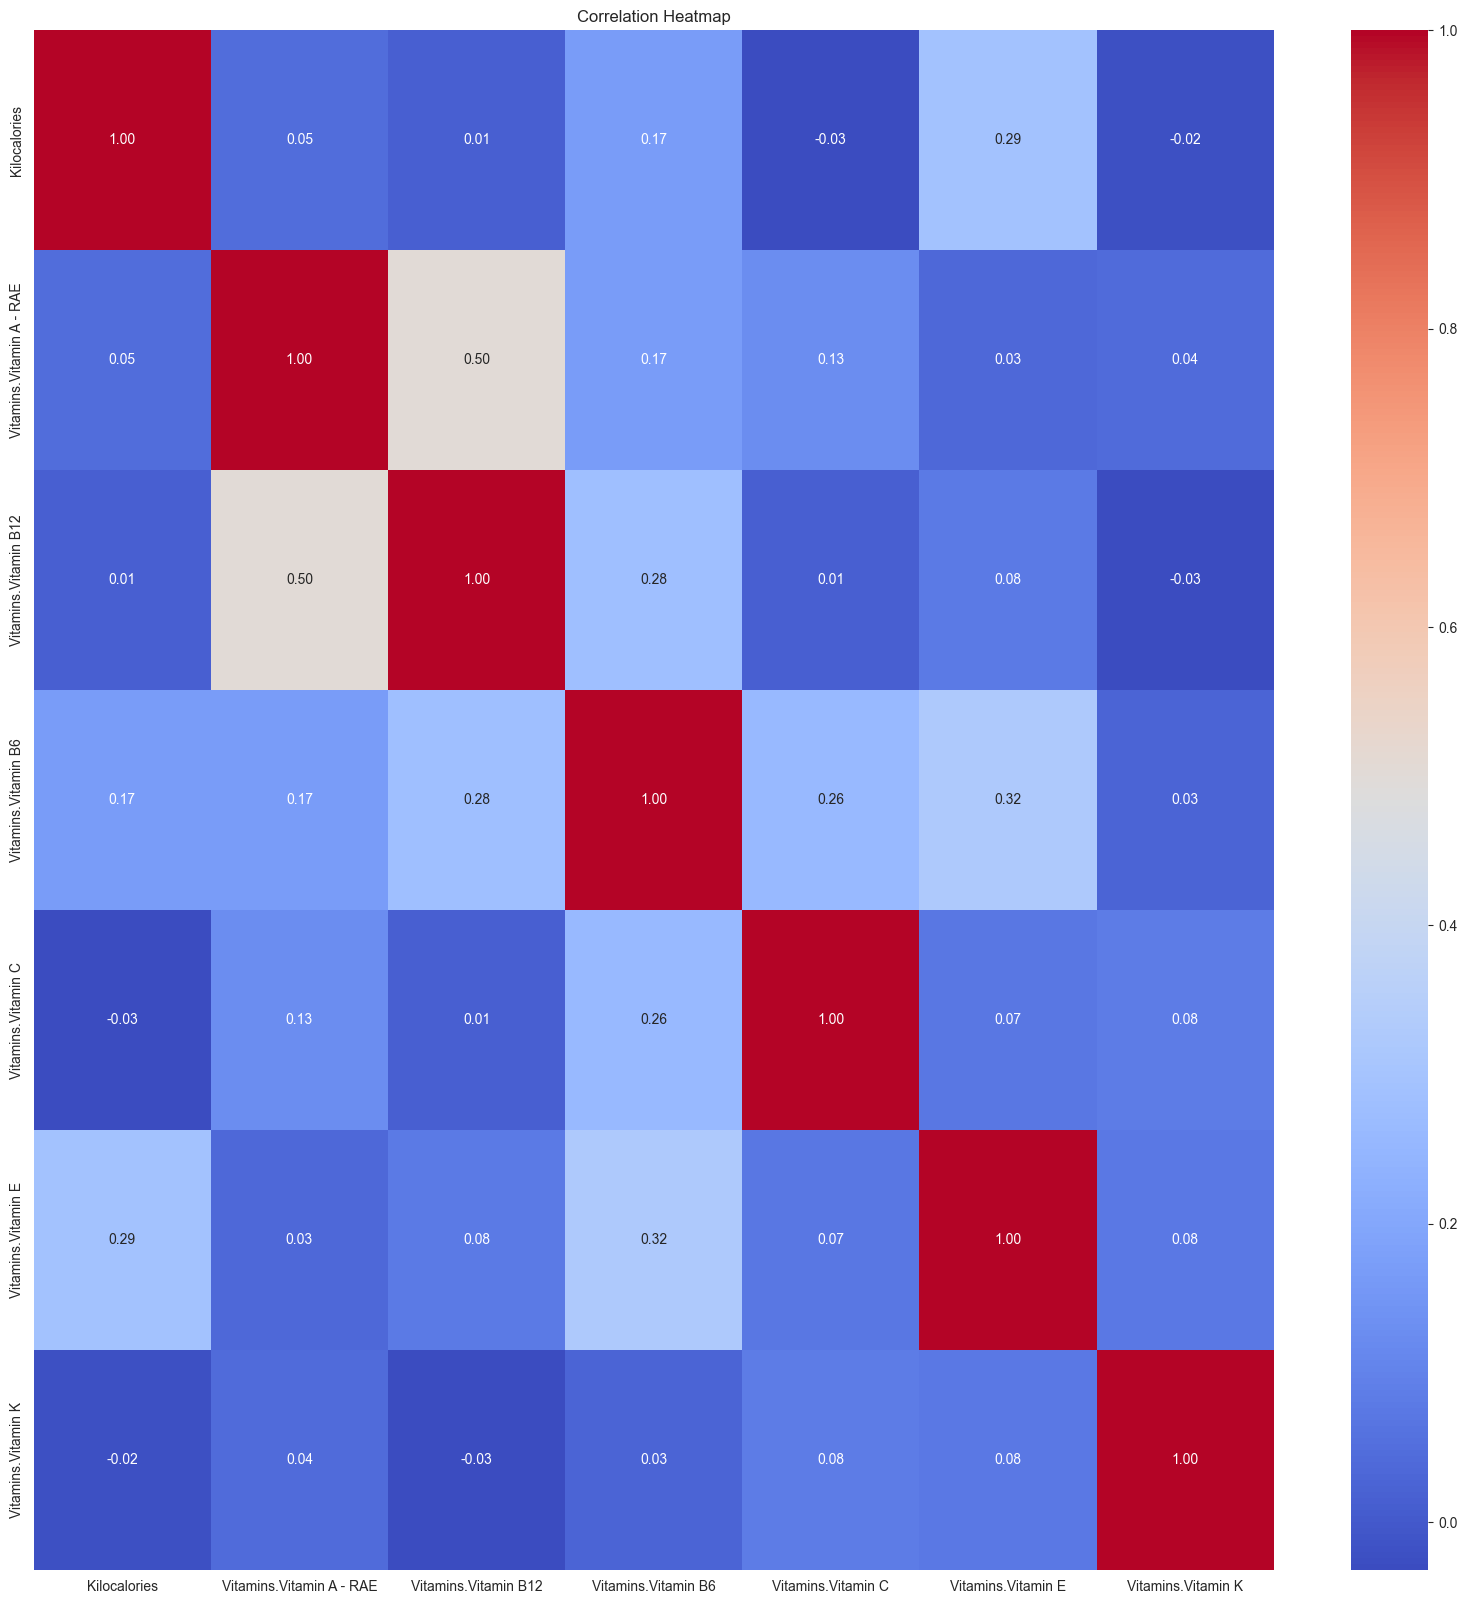

In [775]:
# Create a copy of the dataset
df_fs_correlation = dff.copy()

# Only keep the columns where column name like 'Kilocalories' or 'Vitamins.x'
df_fs_correlation = df_fs_correlation.filter(regex='Kilocalories|Vitamins.*')

# Create a correlation matrix of all independent variables
corr_matrix = df_fs_correlation.corr()

# Create a heatmap of all independent variables
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [776]:
# Create a dummy column called 'Vitamins.Vitamin B12' that is 1 if Vitamin B12 is present and 0 if it is not
dff['Vitamins.Vitamin B12 Present'] = np.where(dff['Vitamins.Vitamin B12'] > 0, 1, 0)

# Drop the 'Vitamins.Vitamin B12' column
dff.drop(['Vitamins.Vitamin B12'], axis=1, inplace=True)

Finally, let's drop the *Data Bank Number* column because it is a surrogate key and the *Category* and *Description* columns because they are categorical variables that we are not going to be using in our model.

In [777]:
# Drop the 'Data Bank Number', 'Category', and 'Description' columns
dff.drop(['Category', 'Description', 'Nutrient Data Bank Number'], axis=1, inplace=True)

## Relationships Between Predictors and Response
Let's take a look at the relationship between the predictors and the response variable. We will do this by performing an OLS on the data and looking at the p-values of the coefficients.

In [778]:
# Compute the OLS
y = 'Kilocalories'
X = list(dff.columns)
X.remove(y)
ols = sm.OLS(dff[y], dff[X]).fit()

# Print the summary
print(ols.summary())

                                 OLS Regression Results                                
Dep. Variable:           Kilocalories   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          5.301e+04
Date:                Thu, 02 Nov 2023   Prob (F-statistic):                        0.00
Time:                        21:58:27   Log-Likelihood:                         -29067.
No. Observations:                6943   AIC:                                  5.821e+04
Df Residuals:                    6903   BIC:                                  5.849e+04
Df Model:                          40                                                  
Covariance Type:            nonrobust                                                  
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------

**Is the relationship significant?** We can see that the p-value is less than 0.05 for just a few predictors, where Fat Total Lipids has the largest positive relationship between to the response with a coefficient of 8.8. The following predictors have a significant relationship with the response as well:

2. Protein : 4.27
3. Carbohydrate : 3.9950
4. Minerals.Copper : -2.6688
5. Vitamin B6 : -2.23 
6. Fiber : -1.64
7. Niacin : 0.1654
8. Zinc : 0.1208
9. Magnesium : -0.05
10. Vitamin E : 0.044
11. Water : 0.0341
12. Vitamin C : -0.033
13. Selenium : 0.0156
14. Magnesium : -0.05
15. Beta Cryptoxanthin : -0.006
16. Household Weights.1st Household Weight : -0.0021


A few of these predictors are a bit suspect; for example, I'd expect Water to have a much higher coefficient than Copper or Zinc.

In [779]:
# Compute the VIF Scores for each predictor
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe to store the VIF Scores
vif_data = pd.DataFrame()

# Setting the predictor and response variables for the VIF Scores
y = 'Kilocalories'
X = list(dff.columns)
X.remove(y)
MultiCollinearity = dff[X]

# Add the column names to the dataframe
vif_data["feature"] = MultiCollinearity.columns

# Compute the VIF Scores for each predictor in dff
vif_data["VIF"] = [variance_inflation_factor(MultiCollinearity.values, i) for i in range(len(MultiCollinearity.columns))]

# Print the VIF Scores
print(vif_data)

                                   feature        VIF
0                           Alpha Carotene   2.224417
1                                      Ash  14.197231
2                            Beta Carotene   5.277071
3                       Beta Cryptoxanthin   1.354658
4                             Carbohydrate   3.681503
5                              Cholesterol   1.425366
6                                  Choline   1.675588
7                                    Fiber   2.426427
8                    Lutein and Zeaxanthin   2.142672
9                                 Lycopene   1.026158
10                               Manganese   1.247682
11                                  Niacin   6.815115
12                        Pantothenic Acid   2.027455
13                                 Protein   5.091745
14                       Refuse Percentage   1.430483
15                                 Retinol  97.848229
16                              Riboflavin   4.969359
17                          

**Is there any multicollinearity in the model? Are predictor variables independent of all the other predictor variables?** We can see that the VIF scores are very high for a few predictors. Taking a closer look, we can see logical multi-collinearity between the following high-scoring predictors:
* Fat Total Lipids and other Fat predictors
* Retinol and Vitamin A predictors

This makes total sense since Total Fat is the sum of the other Fat predictors and Retinol is a form of Vitamin A.

**Are any model assumptions violated?** Let's quickly see some qq plots to understand if any predictors aren't normal.

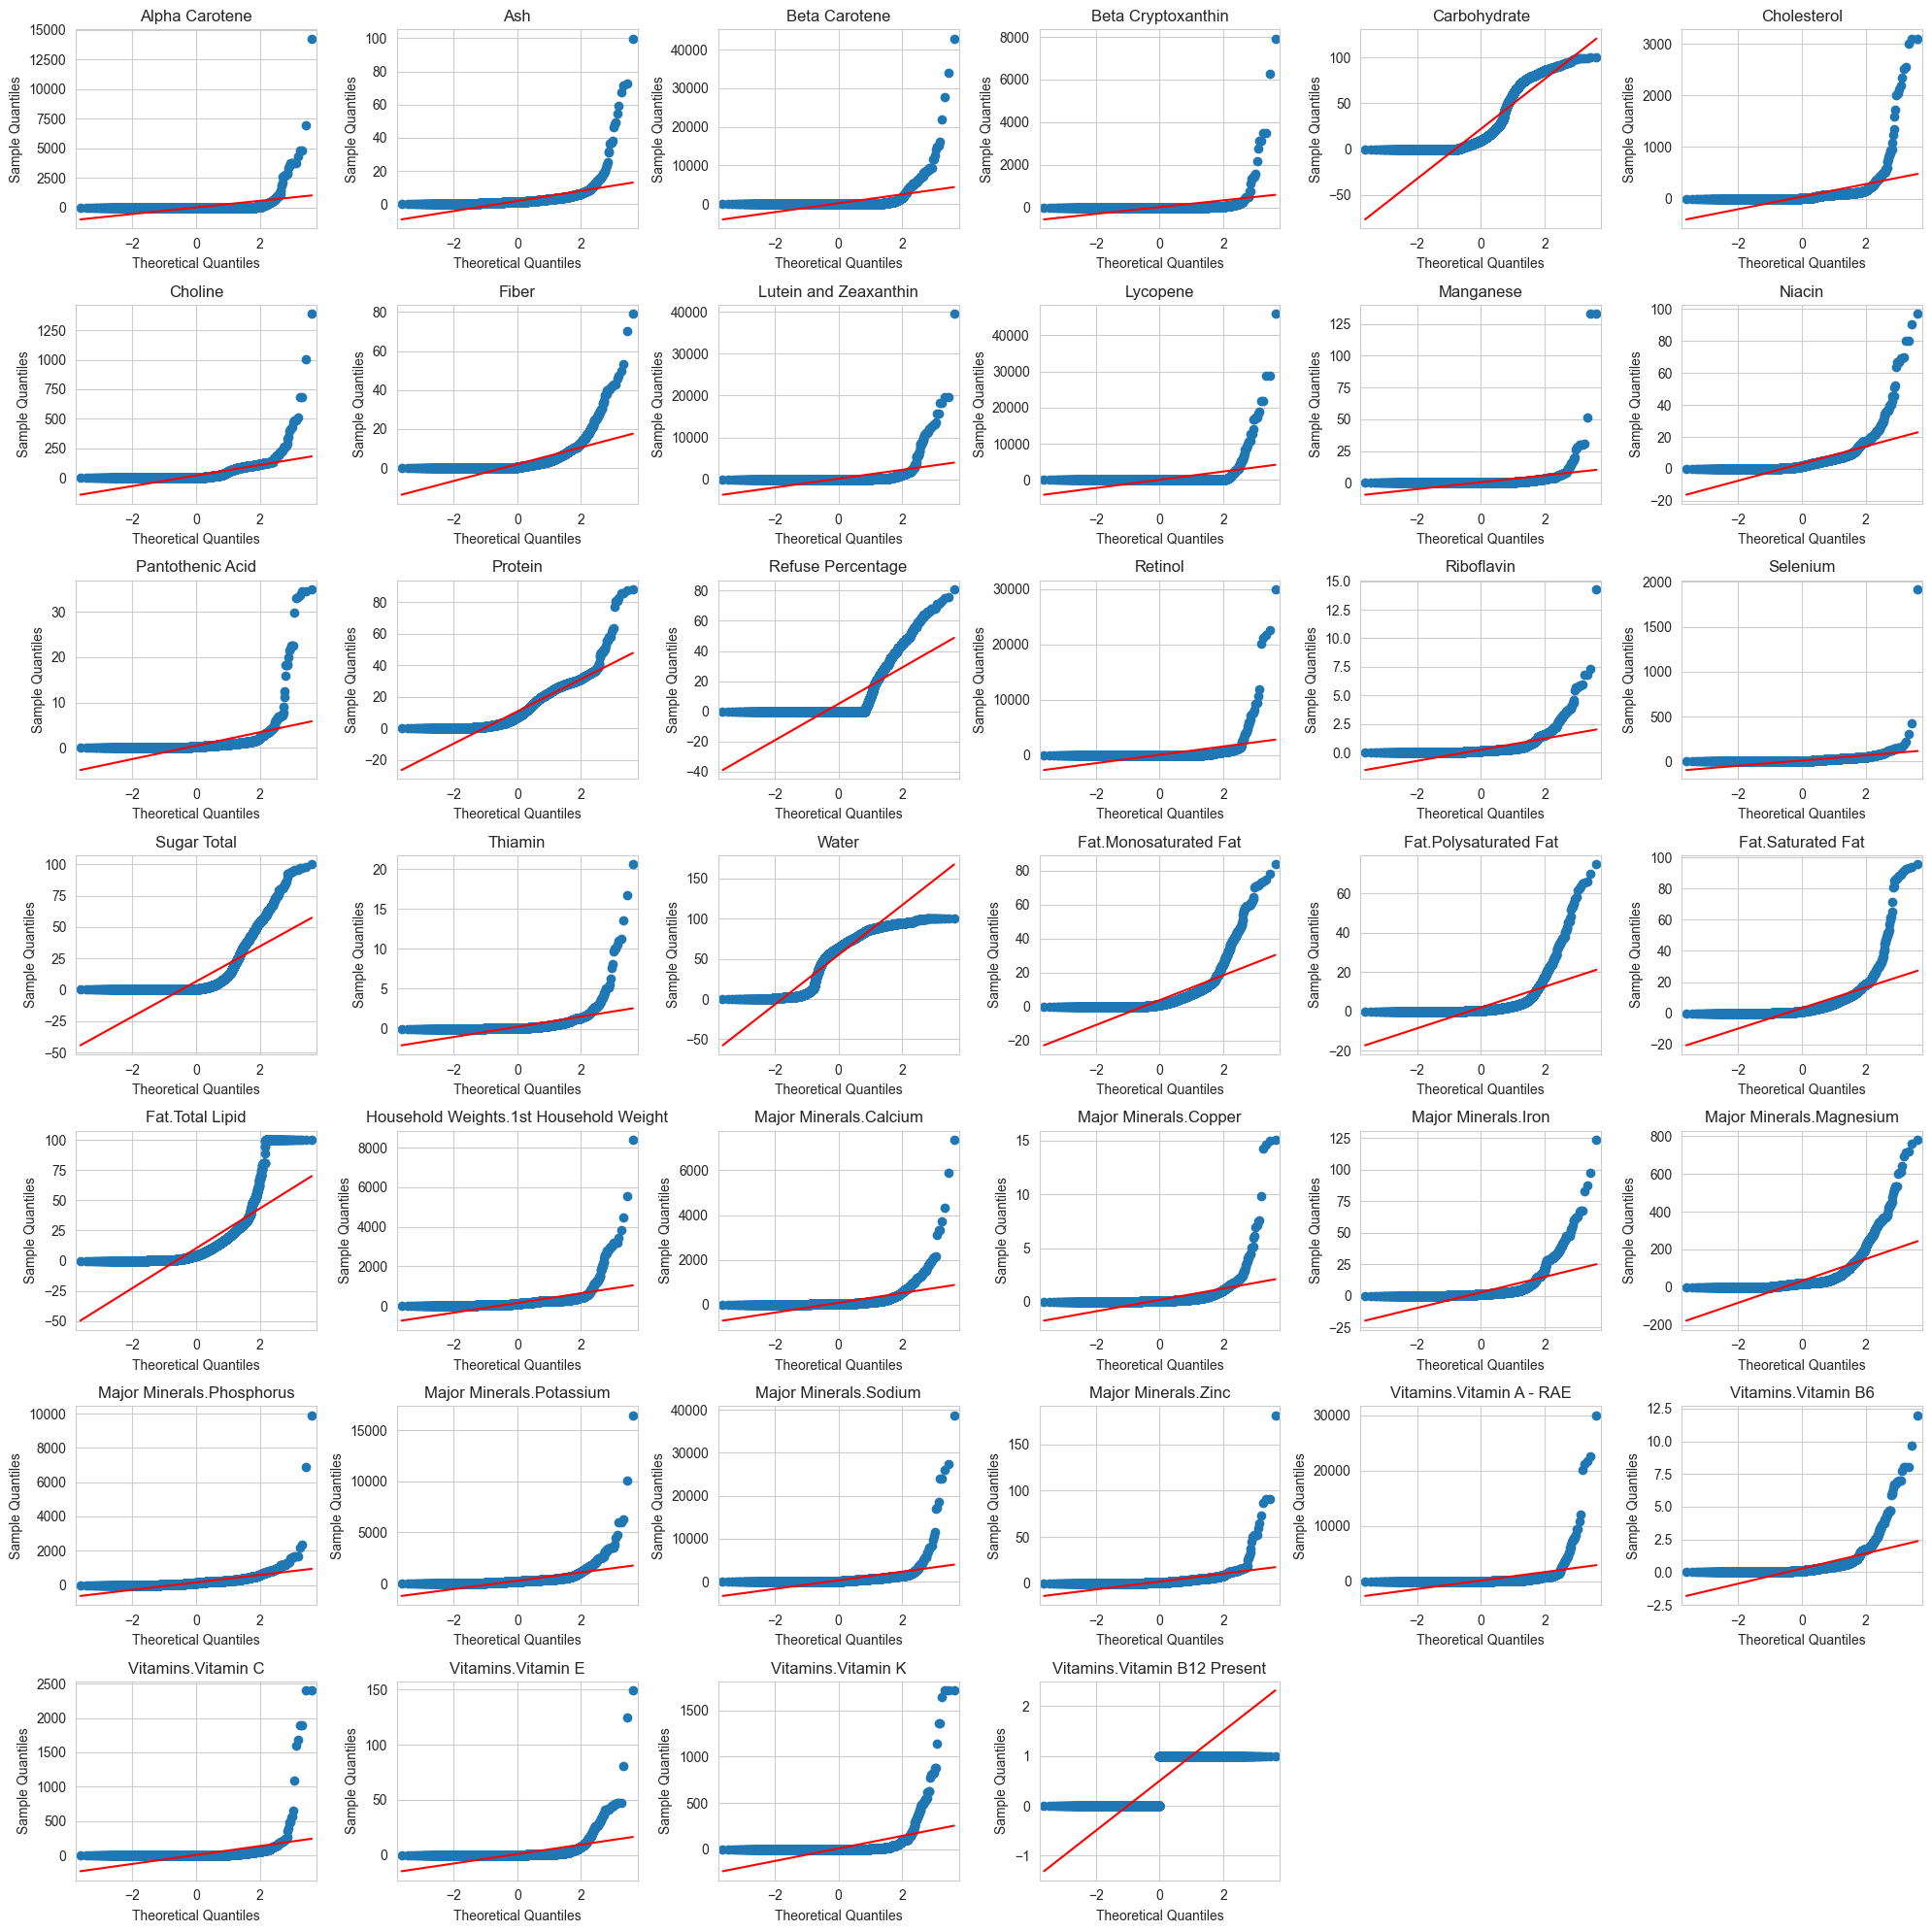

In [780]:
# Create a grid of qq plots for each predictor
fig, axes = plt.subplots(7, 6, figsize=(20, 20))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(X):
        sm.qqplot(dff[X[i]], line='s', ax=ax)
        ax.set_title(X[i])
    else:
        ax.set_visible(False)
plt.tight_layout()
plt.show()


We can see above that none of these predictors are normally distributed. This is not surprising since we are dealing with a variety of foods and with drastically different weights and sizes. The dataset covers small snacks to entire meals. This does violate our assumption of normality which may throw off our GBM and GLM models below, but we will not be addressing this in this project.

## Creating Training and Test Sets and Generating Models with H2O
Let's load the pre-processed data into an H2O frame and split it up into training and test sets. We will use 80% of the data for training and 20% for testing.

Remember, our predictors will be all the remaining columns except for *Kilocalories*, our response variable.

In [781]:
# Show initial shape of dataframe
print('Initial shape of dataframe:', dff.shape)

Initial shape of dataframe: (6943, 41)


In [782]:
# Convert the dataframe to an H2OFrame
df = h2o.H2OFrame(dff)

# Splitting the data into training and test sets
pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows], seed = 1)

# Show shape of training set and test set
print('Training set shape:', df_train.shape)
print('Test set shape:', df_test.shape)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training set shape: (5568, 41)
Test set shape: (1375, 41)


In [783]:
# Setting the predictor and response variables
y = 'Kilocalories'
X = list(df.columns)
X.remove(y)

# Print predictors
print('Predictors:', X)

# Print response variable
print('Response:', y)

Predictors: ['Alpha Carotene', 'Ash', 'Beta Carotene', 'Beta Cryptoxanthin', 'Carbohydrate', 'Cholesterol', 'Choline', 'Fiber', 'Lutein and Zeaxanthin', 'Lycopene', 'Manganese', 'Niacin', 'Pantothenic Acid', 'Protein', 'Refuse Percentage', 'Retinol', 'Riboflavin', 'Selenium', 'Sugar Total', 'Thiamin', 'Water', 'Fat.Monosaturated Fat', 'Fat.Polysaturated Fat', 'Fat.Saturated Fat', 'Fat.Total Lipid', 'Household Weights.1st Household Weight', 'Major Minerals.Calcium', 'Major Minerals.Copper', 'Major Minerals.Iron', 'Major Minerals.Magnesium', 'Major Minerals.Phosphorus', 'Major Minerals.Potassium', 'Major Minerals.Sodium', 'Major Minerals.Zinc', 'Vitamins.Vitamin A - RAE', 'Vitamins.Vitamin B6', 'Vitamins.Vitamin C', 'Vitamins.Vitamin E', 'Vitamins.Vitamin K', 'Vitamins.Vitamin B12 Present']
Response: Kilocalories


### AutoML Execution with H2O
This is the easy part - let's use H2O's AutoML to generate the 5 models for this dataset. We will not be using the resulting models from this step, but we will use the leaderboard to get an idea of how the best performing models do on this data.

Using the Virtual Machine config defined above, I will train the models on the training set and evaluate them on the test set.

In [786]:
# Set up AutoML
aml = H2OAutoML(seed=1, max_models=5, stopping_metric='RMSE', sort_metric='RMSE', verbosity='info', exclude_algos = ["XGBoost", "DeepLearning"]) # Due to system limitations, I am only including specific algorithms that can run on my local machine for reproducibility

In [787]:
# Pass the data through H20AutoML set the seed for reproducibility
aml.train(x=X, y=y, training_frame=df_train, validation_frame=df_test)

AutoML progress: |
22:00:45.411: Project: AutoML_1_20231102_220045
22:00:45.414: 5-fold cross-validation will be used.
22:00:45.414: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
22:00:45.416: Setting stopping tolerance adaptively based on the training frame: 0.013401406685472435
22:00:45.416: Build control seed: 1
22:00:45.418: training frame: Frame key: AutoML_1_20231102_220045_training_py_1184_sid_9ee0    cols: 41    rows: 5568  chunks: 1    size: 517534  checksum: 8148714463221534191
22:00:45.419: validation frame: Frame key: py_1185_sid_9ee0    cols: 41    rows: 1375  chunks: 1    size: 125123  checksum: -3524277677138668100
22:00:45.419: leaderboard frame: NULL
22:00:45.419: blending frame: NULL
22:00:45.419: response column: Kilocalories
22:00:45.419: fold column: null
2

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/5
# GBM base models (used / total),2/3
# DRF base models (used / total),1/1
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


We'll ignore the best model for now. Let's take a look at the leaderboard.

In [788]:
# View the AutoML Leaderboard
lb = aml.leaderboard

# Print ranked models. Show as dataframe so we can see model indices.
lb.head().as_data_frame()

,model_id,rmse,mse,mae,rmsle,mean_residual_deviance
0,StackedEnsemble_AllModels_1_AutoML_1_20231102_...,11.866082,140.803896,5.668007,NaN,140.803896
1,StackedEnsemble_BestOfFamily_1_AutoML_1_202311...,11.906419,141.762822,5.711210,0.127102,141.762822
2,GBM_3_AutoML_1_20231102_220045,12.408519,153.971337,6.286516,0.132622,153.971337
3,GBM_2_AutoML_1_20231102_220045,12.973555,168.313124,6.531669,NaN,168.313124
4,DRF_1_AutoML_1_20231102_220045,13.397031,179.480440,6.590093,0.136745,179.480440
5,GLM_1_AutoML_1_20231102_220045,14.950722,223.524097,7.349560,NaN,223.524097
6,GBM_1_AutoML_1_20231102_220045,16.381891,268.366338,7.941983,NaN,268.366338


This gives a good idea of ideal performance. In the next steps, however, I'll be focusing on 2 algorithms: 
* Model 1: GBM | H2OGradientBoostingEstimator
* Model 2: GLM | H2OGeneralizedLinearEstimator

## Model Tuning and Evaluation
This next section is a bit long and tedious to read. In short, I generate the two models and analyze each model's hyperparameters and predictions. To structure this part, I'll address the following guiding questions:

* **What is the rank the most significant predictor variables?**
* **Does the model make sense?**
* **Which hyperparameters are important?**

Then, I will use some techniques to tweak the model and see if I can answer these questions:
* **Does excluding insignificant variables from the model help RMSE?**
* **Does regularization help reduce RMSE and overfitting?**

### Model 1: GBM
Let's start by generating a GBM model with the training data and see it's performance on cross-validation and testing data. We will use the default parameters for now.

In [789]:
# Create a GBM model with the training data
from h2o.estimators import H2OGradientBoostingEstimator

# Set up GBM for regression
gbm = H2OGradientBoostingEstimator(seed=1, model_id='gbm', nfolds= 5)

# Use .train() to build the model
gbm.train(x=X, y=y, training_frame=df_train, validation_frame=df_test)

# Print the GBM model
print(gbm)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: gbm


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          20750                  5            5            5             18            32            28.3

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 90.7178568775699
RMSE: 9.524592215815327
MAE: 5.465632148857774
RMSLE: 0.1687336207036608
Mean Residual Deviance: 90.7178568775699

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 123.39114631402632
RMSE: 11.10815674691469
MAE: 6.6937143620255055
RMSLE: 0.08

As we tune our model, we want to keep our RMSE performance on the cross-validation set and testing in mind: 11.1 and 13.4. This is our baseline for how much our model is overfitting. An adjustment of a hyperparameter will be considered successful if it reduces the RMSE compared to this benchmark. 

We can also see that the model considers *Water* far and away the most important predictor, followed by *Fat Total Lipids*. Below I'll use the explain function to get visualize the importance.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

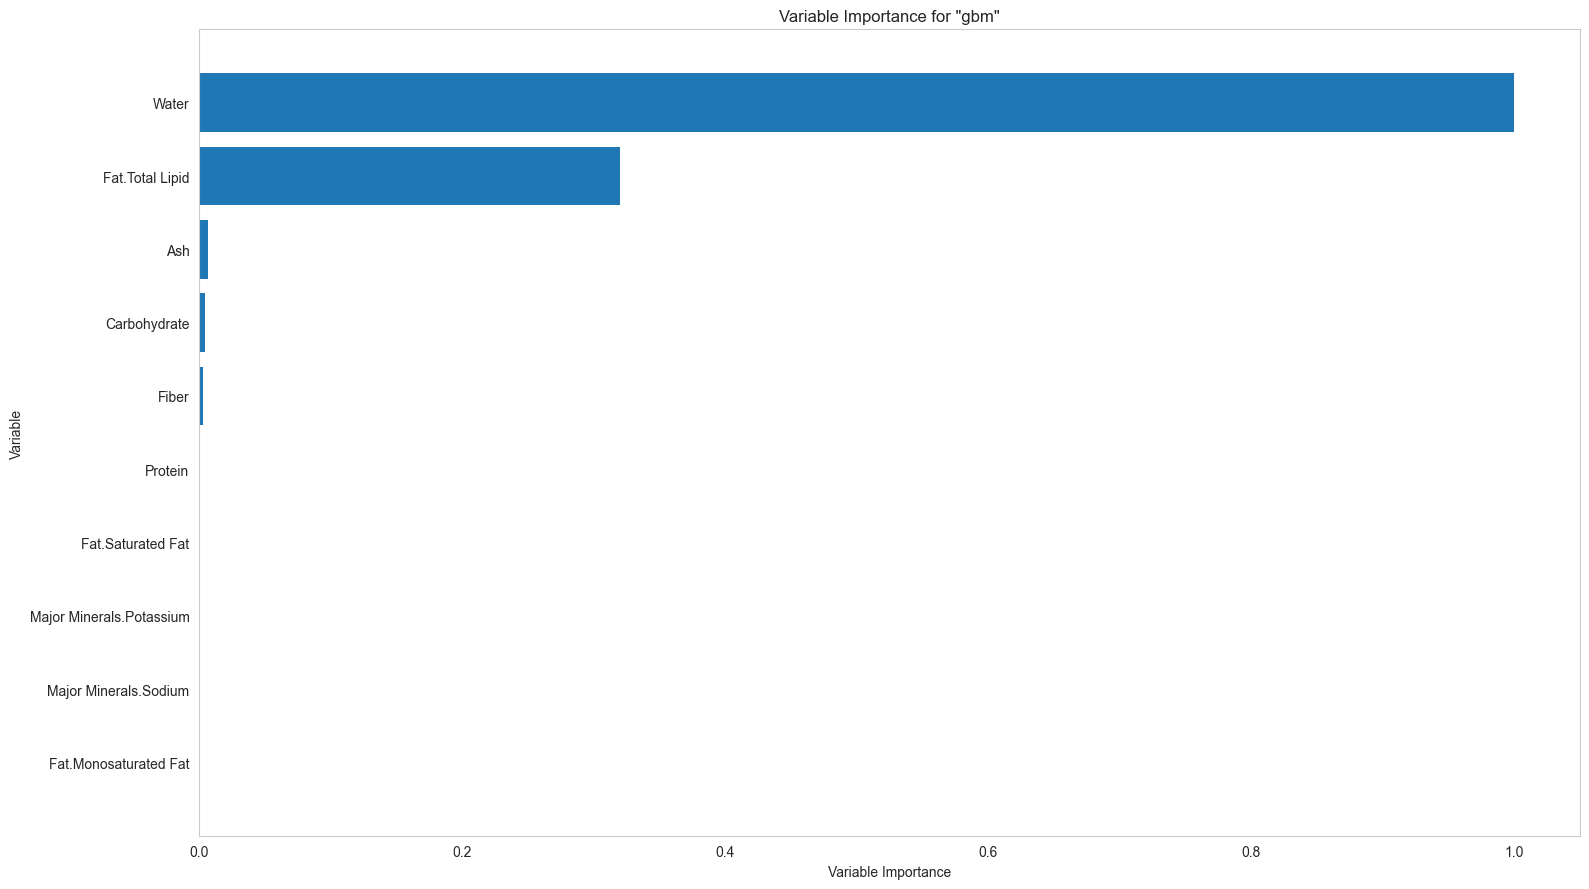

In [790]:
# Plot the variable importance
exm = gbm.explain(df_test, include_explanations=['varimp'])

**What is the rank the most significant predictor variables?** We can rank significant predictors based on these results; for example, *Water* would be the most significant predictor, followed by *Fat.Total Lipids*, etc.

**Does the model make sense?** It makes a lot of sense that water would be a strong predictor of kilocalories. Though we saw above in the OLS regression that it isn't strongly negatively correlated to the response, it is a significant predictor of the response. Water has 0 calories, so food with high water content will have fewer kilocalories. It does not make sense that it would be so much more significant than the other predictors like *Fat Total Lipids*, *Protein*, and *Carbohydrate*, which are essential building blocks of food.

Beyond that, I think this model overstates the importance of insignificant micronutrients like Potassium. Because *Water* is so significant, the model makes it seem like Potassium is as significant as Saturated Fat, which we know is not true. 

In order to test which hyperparameters are important for this GBM instance, I will tweak the following HPs and see how they affect the RMSE on the test set:
* Learn Rate
* ntrees
* Minimum Rows

In [791]:
from h2o.grid import H2OGridSearch

# GBM hyperparameters
gbm_params1 = {
    'learn_rate': [0.01, 0.1],  
    'ntrees': [100, 200],  
    'min_rows': [10, 20]  
}

# Train and validate a cartesian grid of GBMs
gbm_grid1 = H2OGridSearch(model=gbm,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)
gbm_grid1.train(x=X, y=y,
                training_frame=df_train,
                validation_frame=df_test,
                seed=1)

# Get the grid results, sorted by validation RMSE
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='rmse', decreasing=False)


# Let's see the grid
gbm_gridperf1

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,learn_rate,min_rows,ntrees,model_ids,rmse
,0.1,10.0,200.0,gbm_grid1_model_6,12.5328661
,0.1,20.0,200.0,gbm_grid1_model_8,12.7504811
,0.1,10.0,100.0,gbm_grid1_model_2,12.8572603
,0.1,20.0,100.0,gbm_grid1_model_4,13.1897621
,0.01,10.0,200.0,gbm_grid1_model_5,29.0725716
,0.01,20.0,200.0,gbm_grid1_model_7,29.4120764
,0.01,10.0,100.0,gbm_grid1_model_1,66.6440276
,0.01,20.0,100.0,gbm_grid1_model_3,66.6866571


**Which hyperparameters are important?** All else held constant, we can see that Learn Rate has the biggest impact on our RMSE. We can observe smaller changes between two min_row and two ntree valiues, but when Learn Rate decreases from 0.1 to 0.01, RMSE shoots up by up to ~54 Kcals. This makes sense because Learn Rate is the step size of the gradient descent algorithm. A smaller step size means that the algorithm will take longer to converge, but it will be more accurate. The other two hyperparameters, min_rows and ntree, are more related to the complexity of the model.

Now let's see if we can improve the model by excluding insignificant variables from the model and see if that helps RMSE. Based on the variable importance threshold from above, we'll exclude all variables with a scaled importance score of less than 0.0004. 

In [792]:
# Get Variable importance from the GBM model and store it in a dataframe
gbm_varimp = gbm.varimp(use_pandas=True)

# Create a list of the variables with a scaled importance score of greater than 0.004
sig_vars_gbm = list(gbm_varimp[gbm_varimp['scaled_importance'] > 0.0004]['variable'])

# Create a copy of the dataset
df_sig_feats_gbm = dff.copy()

# Drop all columns from the dataset that are not in the list of significant variables or the response variable
df_sig_feats_gbm = df_sig_feats_gbm[sig_vars_gbm + [y]]

# Add data to an H2OFrame and split it into training and test sets
df_sig_feats_gbm = h2o.H2OFrame(df_sig_feats_gbm)
df_sig_feats_gbm_train, df_sig_feats_gbm_test = df_sig_feats_gbm.split_frame([pct_rows], seed=2)

# Set up GBM for regression
gbm_sig_feats = H2OGradientBoostingEstimator(seed=1, model_id='gbm_sig', nfolds= 5)

# Use .train() to build the model
gbm_sig_feats.train(x=sig_vars_gbm, y=y, training_frame=df_sig_feats_gbm_train, validation_frame=df_sig_feats_gbm_test)

# Print the GLM model
print(gbm_sig_feats)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: gbm_sig


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          20976                  5            5            5             22            32            28.66

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 103.06722347612913
RMSE: 10.152202887852917
MAE: 5.742956566472274
RMSLE: 0.1468470941491202
Mean Residual Deviance: 103.06722347612913

ModelMetricsRegression: gbm
** Reported on

**Does excluding insignificant variables from the model help RMSE?** Looking at the RMSE score after removing insignificant variables, we can see that it is 10.02 (vs. 11.1) on the testing data and 13.5 (13.4) on the cross-validation data. This model seems to have performed well on the test set, but we must take it with a grain of salt, given our results on the cross-validation set. This does show that we can reduce overfitting by removing insignificant variables.

Now let's see if some regularization techniques will help reduce overfitting. Let's start by adjusting the max_depth hyperparameter. This parameter controls the maximum depth of individual trees, which thereby limits the complexity of the model.

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


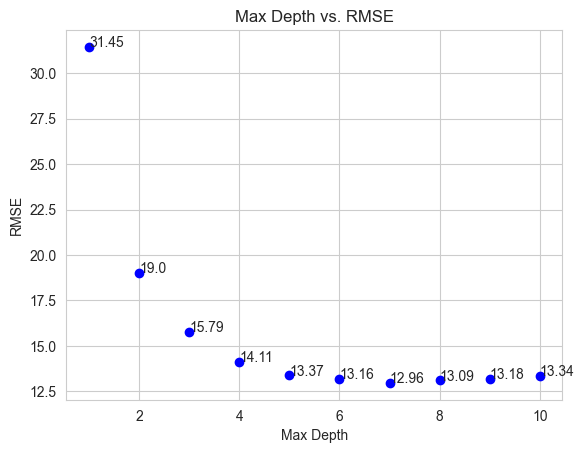

In [793]:
# Regularize model2 with max_depth
from h2o.estimators import H2OGradientBoostingEstimator

# select the values for max_depth to grid over
hyper_params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Train and validate a cartesian grid of GBMs
gbm_grid = H2OGridSearch(model=gbm,
                          grid_id='gbm_grid',
                          hyper_params=hyper_params,)

# Train the grid
gbm_grid.train(x=X, y=y, training_frame=df_train, validation_frame=df_test)

# Get the grid results, sorted by validation RMSE
gbm_gridperf = gbm_grid.get_grid(sort_by='rmse', decreasing=True)

# Add the grid models to a dataframe
gbm_gridperf_df = gbm_gridperf._grid_json['summary_table'].as_data_frame()

# Plot max depth vs. RMSE
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('Max Depth vs. RMSE')
plt.plot(gbm_gridperf_df['max_depth'], gbm_gridperf_df['rmse'], 'bo')
for i, txt in enumerate(gbm_gridperf_df['rmse']):
    # round to 2 decimals
    txt = round(txt, 2)
    plt.annotate(txt, (gbm_gridperf_df['max_depth'][i], gbm_gridperf_df['rmse'][i]))
plt.show()

**[Max Depth] Does regularization help reduce overfitting and RMSE?** We can see that the RMSE decreases as the max_depth increases to a point. This makes sense because the model is able to learn more complex relationships between the predictors and the response. However, we can see that the RMSE starts to increase again after max_depth = 7. If we look back to our original GBM model's performance and compare RMSE scores, we can see that the best value of this tuning exercise gave us 11.1 on the test set, whereas we got down to 12.96; we never get to our minimum RMSE here. 

This hyperparameter certainly has an impact on our model and how much it overfits, but it doesn't seem to be the most important lever for reducing overfitting.

Let's try one more regularization technique: adjusting sample rate. This parameter controls the row sampling rate which controls the number of rows used in training each tree.

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


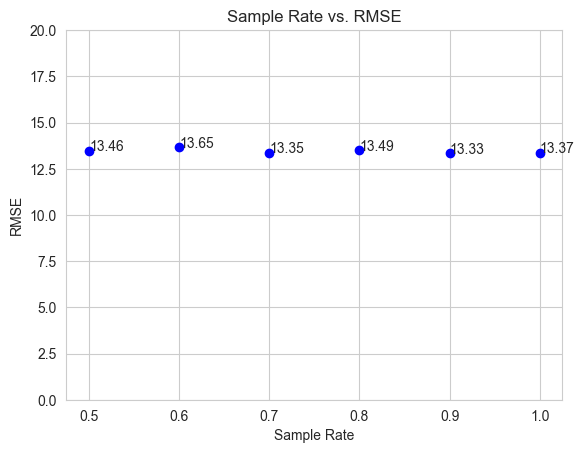

In [794]:
# Regularize model2 with sample_rate
from h2o.estimators import H2OGradientBoostingEstimator

# select the values for sample_rate to grid over
hyper_params = {'sample_rate': [0.5, 0.6, 0.7, 0.8, 0.9, 1]}

# Train and validate a cartesian grid of GBMs
gbm_grid2 = H2OGridSearch(model=gbm,
                          grid_id='gbm_grid2',
                          hyper_params=hyper_params)

# Train the grid
gbm_grid2.train(x=X, y=y, training_frame=df_train, validation_frame=df_test, seed=1, nfolds=5)

# Get the grid results, sorted by validation RMSE
gbm_gridperf2 = gbm_grid2.get_grid(sort_by='rmse', decreasing=True)

# Add the grid models to a dataframe
gbm_gridperf_df2 = gbm_gridperf2._grid_json['summary_table'].as_data_frame()

# Plot sample rate vs. RMSE
plt.xlabel('Sample Rate')
plt.ylabel('RMSE')
plt.title('Sample Rate vs. RMSE')
# Set y axis min to 0 and max to 20
plt.ylim(0, 20)
plt.plot(gbm_gridperf_df2['sample_rate'], gbm_gridperf_df2['rmse'], 'bo')
for i, txt in enumerate(gbm_gridperf_df2['rmse']):
    # round to 2 decimals
    txt = round(txt, 2)
    plt.annotate(txt, (gbm_gridperf_df2['sample_rate'][i], gbm_gridperf_df2['rmse'][i]))
plt.show()

**[Sample Rate] Does regularization help reduce overfitting and RMSE?** After limited testing and because our best RMSE (13.37) is greater than or equal to that of our base model for each test HP, we can conclude that adjusting this hyperparameter not as important as max_depth for reducing overfitting or residuals. There are many hyperparameters we can adjust to regularize and counteract overfitting in our GBM models, but we will stop here for now. Read more about GBM hyperparameters [here](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html#gbm-hyperparameters).

#### Model 2: GLM
Let's now train a GLM model with the same training data as the GBM model and see how it performs on cross-validation and testing data. We will use the default parameters for now.

In [795]:
# Create a GLM model with the same training data as the GBM model
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

# Set up GLM for regression
glm = H2OGeneralizedLinearEstimator(family='gaussian',
                                    seed=1,
                                    model_id='glm', nfolds= 5)

# Use .train() to build the model
glm.train(x=X, y=y, training_frame=df_train, validation_frame=df_test)

# Print the GLM model
print(glm)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: glm


GLM Model: summary
    family    link      regularization                               number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.3074 )  40                            37                             1                       py_1184_sid_9ee0

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 413.9500638742513
RMSE: 20.345762799026517
MAE: 13.528871580183655
RMSLE: NaN
Mean Residual Deviance: 413.9500638742513
R^2: 0.9861617009584553
Null degrees of freedom: 5567
Residual degrees of freedom: 5530
Null dev

When running this model across our cross-validation data we get a 22.7 RMSE vs. an 18.5 on our test set. Again, we should keep this in mind as a benchmark to assess our tuning, rather than focusing on performance based on training. We can also see our model did better on our testing rather than training (20.3 RMSE), which makes this hard to interpret, but seems like a sign we're not overfitting.

**What is the rank the most significant predictor variables?**
We can also see that the model considers *Water* far and away the most important predictor, followed by *Fat Total Lipids*. Below I'll use the explain function to get visualize the importance.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

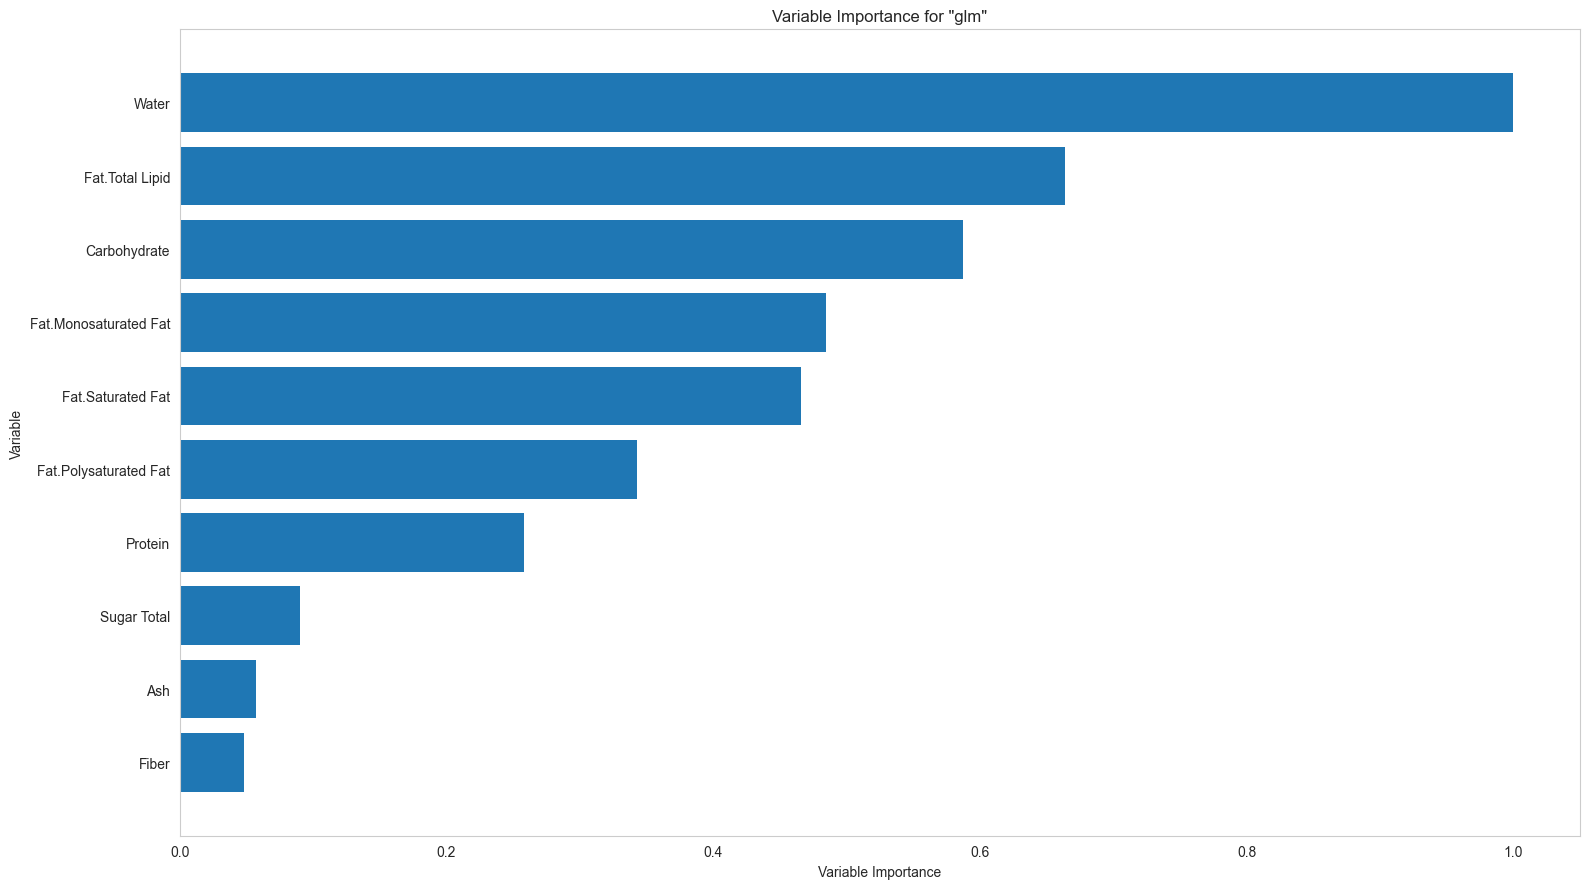

In [796]:
# Plot the variable importance
exm = glm.explain(df_test, include_explanations=['varimp'])

We can rank significant predictors based on these results; for example, *Water* would be the most significant predictor, followed by *Fat Total Lipids*, *Carbohydrate*, etc.

**Does the model make sense?** It makes a lot of sense that water would be a strong predictor of kilocalories. Though we saw above in the OLS regression that it isn’t strongly negatively correlated to the response, it is a significant predictor of the response. 

Opposed to our GBM model, the predictor significance makes much more sense. We can see that the scaled importance is much more representative of what we know to be true: Fats have more calories than Carbohydrates, which have more calories than Protein, etc.

Because of multicollinearity issues with Fat, we see subsets of the Total fat predictors as significant predictors. This makes sense, but hurts interpretability. 

In order to test which hyperparameters are important for this GBM instance, I will tweak the following HPs and see how they affect the RMSE: 
* Dispersion Learning Rate 
* Theta 

In [797]:
from h2o.grid import H2OGridSearch

# GLM hyperparameters
glm_params = { 'dispersion_learning_rate': [0.01, 0.1, 0.5, 1],
                'theta': [1.5, 1.8]
                }

# Train and validate a cartesian grid of GLM
glm_grid_theta_dpl = H2OGridSearch(model=glm, grid_id='glm_grid_theta_dpl1',
                          hyper_params=glm_params)
glm_grid_theta_dpl.train(x=X, y=y,
                training_frame=df_train,
                validation_frame=df_test, nfolds= 5,
                                    seed=1)

# Get the grid results, sorted by validation RMSE
glm_grid_hp = glm_grid_theta_dpl.get_grid(sort_by='rmse', decreasing=False)

# Show the models with varied Hyperparameters
glm_grid_hp

glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,dispersion_learning_rate,theta,model_ids,rmse
,0.01,1.5,glm_grid_theta_dpl1_model_1,22.6541074
,0.1,1.5,glm_grid_theta_dpl1_model_2,22.6541074
,0.5,1.5,glm_grid_theta_dpl1_model_3,22.6541074
,1.0,1.5,glm_grid_theta_dpl1_model_4,22.6541074
,0.01,1.8,glm_grid_theta_dpl1_model_5,22.6541074
,0.1,1.8,glm_grid_theta_dpl1_model_6,22.6541074
,0.5,1.8,glm_grid_theta_dpl1_model_7,22.6541074
,1.0,1.8,glm_grid_theta_dpl1_model_8,22.6541074


**Which hyperparameters are important?** Interestingly, there seems to be no impact on performance for either tuning parameter. Because theta is commonly used on a compound Poisson-gamma distribution, changing it on our abnormal distributions has no impact. Also, changes in the dispersion parameter, which primarily affect the variance of the response distribution, aren't always reflected in RMSE.

We'll see if alpha and lambda parameters affect performance when we try to regularize later.

Before that, let's see if we can improve the model by excluding insignificant variables from the model and see if that helps RMSE. Based on the variable importance threshold from above, we'll exclude all variables with a scaled importance score of less than 0.005. 

In [798]:
# Get Variable importance from the GLM model and store it in a dataframe
glm_varimp = glm.varimp(use_pandas=True)

# Create a list of the variables with a scaled importance score of greater than 0.05
sig_vars = list(glm_varimp[glm_varimp['scaled_importance'] > 0.05]['variable'])

# Create a copy of the dataset
df_sig_feats_glm = dff.copy()

# Drop all columns from the dataset that are not in the list of significant variables or the response variable
df_sig_feats_glm = df_sig_feats_glm[sig_vars + [y]]

# Add data to an H2OFrame and split it into training and test sets
df_sig_feats_glm = h2o.H2OFrame(df_sig_feats_glm)
df_sig_feats_glm_train, df_sig_feats_glm_test = df_sig_feats_glm.split_frame([pct_rows], seed=1)

# Create a GLM model with the training data
glm_sig_feats = H2OGeneralizedLinearEstimator(family='gaussian',
                                    model_id='glm_sig_feats', nfolds= 5,
                                    seed=1)

# Use .train() to build the model
glm_sig_feats.train(x=sig_vars, y=y, training_frame=df_sig_feats_glm_train, validation_frame=df_sig_feats_glm_test)

# Print the GLM model
print(glm_sig_feats)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: glm_sig_feats


GLM Model: summary
    family    link      regularization                               number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.3074 )  9                             9                              1                       py_1219_sid_9ee0

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 464.0243828026844
RMSE: 21.541225192701653
MAE: 14.535461874931256
RMSLE: 0.32865967719964656
Mean Residual Dev

**Does excluding insignificant variables from the model help RMSE?** We can see that excluding insigificant predictors not only fails to improve RMSE on our test set (18.5 -> 19.7), but the cross-validation shows no real change (22.7 -> 22.9). By removing the "insignificant" predictors, we have lost some important signal. We should consider a different threshold for significance in future testing.

Now let's see if some specific regularization techniques will help reduce overfitting. Let's start by adjusting the lambda hyperparameter. 

In [799]:
# Regularize model2 with L2 (Ridge) regularization
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# select the values for lambda_ to grid over
hyper_params = {'lambda': [1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0], 'alpha': [0]}

# Train and validate a cartesian grid of GLMs
glm_grid_reg = H2OGridSearch(model=glm,
                          grid_id='glm_grid2',
                          hyper_params=hyper_params)

# Train the grid
glm_grid_reg.train(x=X, y=y, training_frame=df_train, validation_frame=df_test)

# Get the grid results, sorted by validation RMSE
glm_gridperf_reg = glm_grid_reg.get_grid(sort_by='rmse', decreasing=False)

# Create a dataframe of the grid results
glm_gridperf_reg_df = glm_gridperf_reg._grid_json['summary_table'].as_data_frame()

# Print the grid models sorted by RMSE
print(glm_gridperf_reg_df)

glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
     alpha   lambda          model_ids       rmse
0      0.0  0.00100  glm_grid2_model_5  13.738632
1      0.0  0.00010  glm_grid2_model_6  13.842571
2      0.0  0.00001  glm_grid2_model_7  13.872373
3      0.0  0.00000  glm_grid2_model_8  13.876063
4      0.0  0.01000  glm_grid2_model_4  14.650888
5      0.0  0.10000  glm_grid2_model_3  19.640556
6      0.0  0.50000  glm_grid2_model_2  39.369661
7      0.0  1.00000  glm_grid2_model_1  57.096089


/Users/vraosharma/Desktop/Python/DSEMT/exploratory-data-analysis/venv/lib/python3.10/site-packages/h2o/grid/grid_search.py:429: UserWarning: Adding alpha array to hyperparameter runs slower with gridsearch. This is due to the fact that the algo has to run initialization for every alpha value. Setting the alpha array as a model parameter will skip the initialization and run faster overall.
  warnings.warn(w_message)


**[Ridge] Does regularization help reduce RMSE?** We can clearly see that lambda = 0.0010 is an inflection point. This makes sense because we would expect the model MSE to dip slightly before increasing alongside lambda penalties. This does a beautiful job of mitigating model overfitting, bringing RMSE down to 13.7. Let's try Lasso regularization next.

In [800]:
# Regularize glm model with (Lasso) regularization
# select the values for lambda_ to grid over
hyper_params = {'lambda': [1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0], 'alpha': [1]}

# Train and validate a cartesian grid of GLMs
glm_grid_lass = H2OGridSearch(model=glm,
                          grid_id='glm_grid_lass',
                          hyper_params=hyper_params)

# Train the grid
glm_grid_lass.train(x=X, y=y, training_frame=df_train, validation_frame=df_test)

# Get the grid results, sorted by validation RMSE
glm_gridperf_lass = glm_grid_lass.get_grid(sort_by='rmse', decreasing=False)

# Print the grid models sorted by RMSE
print(glm_gridperf_lass)

glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Hyper-Parameter Search Summary: ordered by increasing rmse
    alpha    lambda    model_ids              rmse
--  -------  --------  ---------------------  -------
    1        0.5       glm_grid_lass_model_2  13.4314
    1        0.1       glm_grid_lass_model_3  13.5064
    1        1         glm_grid_lass_model_1  13.6068
    1        0.01      glm_grid_lass_model_4  13.8191
    1        0.001     glm_grid_lass_model_5  13.8692
    1        0.0001    glm_grid_lass_model_6  13.8754
    1        1e-05     glm_grid_lass_model_7  13.876
    1        0         glm_grid_lass_model_8  13.8761


/Users/vraosharma/Desktop/Python/DSEMT/exploratory-data-analysis/venv/lib/python3.10/site-packages/h2o/grid/grid_search.py:429: UserWarning: Adding alpha array to hyperparameter runs slower with gridsearch. This is due to the fact that the algo has to run initialization for every alpha value. Setting the alpha array as a model parameter will skip the initialization and run faster overall.
  warnings.warn(w_message)


**[Lasso] Does regularization help reduce RMSE?** This does an even better job managing our overfitting than Ridge. This makes sense because many of our features are probably redundant and Lasso can drop coefficients down to essentially 0. This brings our RMSE down to 13.4.

## Conclusion

### Finding the Best Version of our Models
Let's visualize our RMSE scores on the test data for Models 1 & 2 and see how they compare. Where applicable, I'll use the best-tuned version of each model for this comparison.

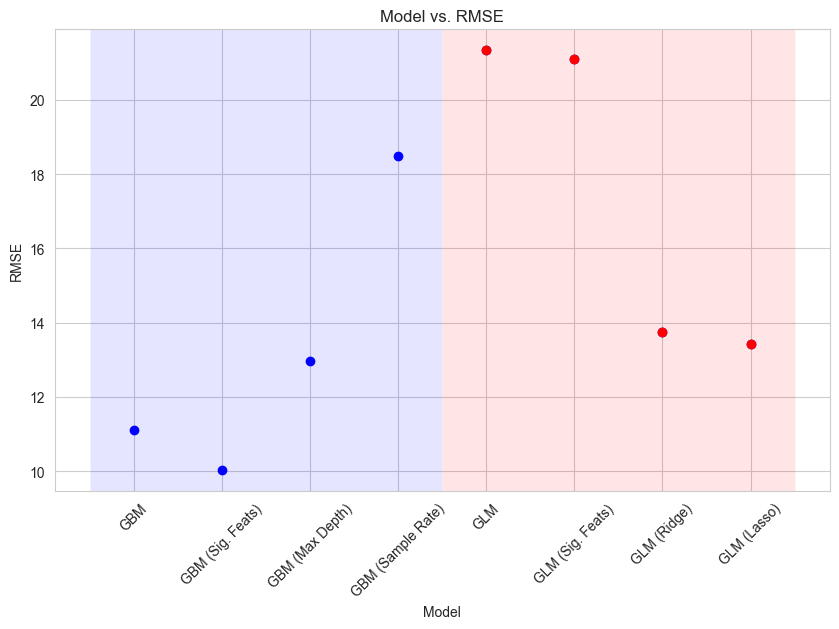

In [801]:
# Create a dataframe for the RMSE scores for each model
df_models = pd.DataFrame({'Model': ['GBM', 'GBM (Sig. Feats)', 'GBM (Max Depth)', 'GBM (Sample Rate)','GLM', 'GLM (Sig. Feats)', 'GLM (Ridge)', 'GLM (Lasso)'], 'RMSE': [11.10815674691469, 10.022526528725216, 12.96, 18.493750320148866, 21.33, 21.087522615205813, 13.738632, 13.4314]})

# Plot the RMSE scores for each model on the same plot
plt.figure(figsize=(10, 6))
plt.plot(df_models['Model'], df_models['RMSE'], 'bo')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model vs. RMSE')
plt.xticks(rotation=45)

# Color different models
plt.axvspan(-0.5, 3.5, facecolor='b', alpha=0.1)
plt.axvspan(3.5, 7.5, facecolor='r', alpha=0.1)

# Turn GLM points red
plt.plot(df_models['Model'][4:], df_models['RMSE'][4:], 'ro')

plt.show()


Overall the best performing model is the GBM model with only significant features and no regularization. This model has the lowest RMSE on the test set.  GBM might be preferred in this case as it can handle high-dimensional data effectively. GLM is more limited in its ability to capture such complex relationships, as it relies on linear combinations of features.

### Comparing Our Models to H2O AutoML Leader  
Remember the leaderboard? Let's take a look at how our best-tuned GLM and GBM compare to the best model generated by H2O AutoML.

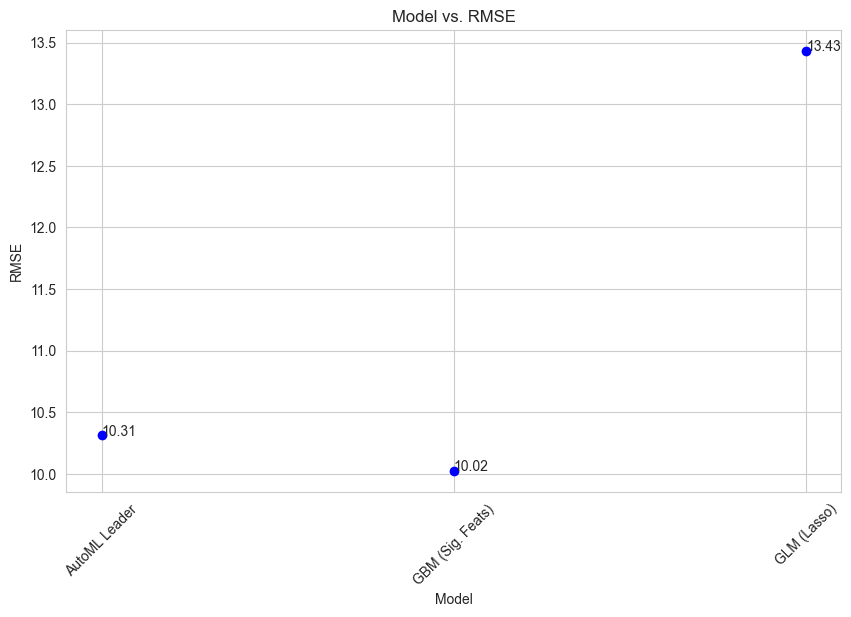

In [802]:
# Get the AutoML Leader
aml_leader = aml.leader

# Get the Leader's RMSE on the test set
aml_leader_rmse = aml_leader.model_performance(df_test).rmse()

# Add the leader from the AutoML leaderboard to a new dataframe with best tuned models
df_conclusion = pd.DataFrame({'Model': ['AutoML Leader', 'GBM (Sig. Feats)', 'GLM (Lasso)'], 'RMSE': [aml_leader_rmse,10.022526528725216,13.4314]})

# Plot the RMSE scores for each model on the same plot
plt.figure(figsize=(10, 6))
plt.plot(df_conclusion['Model'], df_conclusion['RMSE'], 'bo')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model vs. RMSE')
plt.xticks(rotation=45)
# add Rmse values to plot
for i, txt in enumerate(df_conclusion['RMSE']):
    # round to 2 decimals
    txt = round(txt, 2)
    plt.annotate(txt, (df_conclusion['Model'][i], df_conclusion['RMSE'][i]))
plt.show()

Our GBM manages to outperform AutoML Leader. This is surprising since the leader is a Stacked Ensemble model, which, with counteracting biases, often can outperform any individual model. This could be due to the fact that we limited the number of models in our AutoML run to 5, which may have prevented a better Stacked Ensemble from being generated. Additionally, because XGBoost is unavailable on my local machine, we may have missed out on a better model.

## References
Code is my own, but I used the following resources to help me along the way:
1. [Kaggle - Food Nutrition Dataset](https://www.kaggle.com/datasets/shrutisaxena/food-nutrition-dataset?resource=download&select=food.csv)
2. [ML_Data_Cleaning_and_Feature_Selection_Abalone.ipynb](https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/ML_Data_Cleaning_and_Feature_Selection/ML_Data_Cleaning_and_Feature_Selection_Abalone.ipynb)
3. [USDA Food Data Bank](https://fdc.nal.usda.gov/index.html)
4. [NIH Fact Sheet](https://ods.od.nih.gov/factsheets/VitaminA-HealthProfessional/#:~:text=The%20units%20of%20measurement%20for,beta%2Dcarotene%20%3D%200.3%20mcg%20RAE)
5. [Generalized Boosted Models:
A guide to the gbm package](https://www.saedsayad.com/docs/gbm2.pdf)
6. [Generalized Linear Model (GLM)]('https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html?highlight=glm')
7. [From GLM to GBM ]('https://towardsdatascience.com/from-glm-to-gbm-part-2-7045e3fd52a2#:~:text=A%20GLM%20is%20not%20able,such%2C%20preferred%20for%20business%20purposes')
8. [CC_Kaggle_AutoML_Regression_Melbourne_Housing]('https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/CC_Kaggle_AutoML_Regression_Melbourne_Housing.ipynb')
9. [The_World_Happiness_Data]('https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/6105_AutoML_The_World_Happiness_Data.ipynb')
10. [Basics_InnerWorkings_Interpretations]('https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Basics_InnerWorkings_Interpretations.ipynb')
11. [AutoML_Wine_Quality]('https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Wine_Quality.ipynb')
12. [Smoke_Detection]('https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Smoke_Detection_Example.ipynb')

## License
MIT License

Copyright (c) 2023 Vishnu Rao-Sharma

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.